# TKT4108 - Structural Dynamics 2
## Homework 2 - Solution

<img src="Shear Frame_HW2.JPG">

### For a building in Trondheim with behavior factor q = 2, shown above, compute the following earthquake responses assuming Eurocode 8 response spectrum and ground type D:

**- Maximum displacement of first floor**  
**- Maximum base shear**  
**- Maximum overturning moment**  

**Use both Eurocode 8 procedure and theoretical method**

In [1]:
import numpy as np

import scipy.linalg as linalg
import matplotlib.pyplot as plt

# Building Properties
E_c = 40e+9     # concrete elestic modulus in Pa
b_1 = 0.2       # cross section A-A' base and height
b_2 = 0.3       # cross section B-B' base and height
m_1 = 20e+3     # top storey mass in kg
m_2 = 30e+3     # top storey mass in kg
L_1 = 3.00      # height difference between top and first storey
L_2 = 4.00      # height difference between first storey and foundation (clamped end)
q = 2.0         # behaviour factor
a_g = 0.25      # ground acceleration

### Part 1: Modal Analysis
**This part follows the same steps shown and explained in part one "Modal Analysis" of the file:**  
$Example$ - $Earthquake$ $Analysis$ $and$ $EC8$  

**The first step consists on assembling the system stiffness and mass matrices.** 

In [2]:
# Element stifness
I_1 = (1/12)*(b_1)**4           # cross section A-A' inertia moment
I_2 = (1/12)*(b_2)**4           # cross section B-B' inertia moment
k_1 = 2*12*E_c*I_1/(L_1**3)     # DOF1 stifness
k_2 = 2*12*E_c*I_2/(L_2**3)     # DOF2 stifness

# System Matices
K = np.array([[k_1,-k_1],[-k_1,k_2+k_1]])           # stifnees matrix
M = np.array([[m_1,0],[0,m_2]])                     # mass matrix
T = [1,1]                                           # influence vector

**Next, the eigenvalue solution is applied obtaining modes and mode shapes of the system**

In [3]:
# Eigenvale Analysis
lambd, phi = linalg.eig(K, b=M)   
wn = np.sqrt(lambd.real)    # natural circular frequency
Tn = 2*np.pi/wn             # natural period
phi = phi/phi[0,:]          # normalizing shapes

print('The natural circular frequencies are')
print(str(np.around(wn,2)) + ' rad/s')
print( )
print('Then, the natural periods are')
print(str(np.around(Tn,3)) + ' s')
print( )
print('With the corresponding mode shapes')
print(np.around(phi,3))

The natural circular frequencies are
[11.56 24.47] rad/s

Then, the natural periods are
[0.544 0.257] s

With the corresponding mode shapes
[[ 1.     1.   ]
 [ 0.437 -1.527]]


**Modal properties of the system are computed**

In [4]:
# Modal Properties
L_mod = phi.T @ M @ T           # modal expansion of the spatial distribution of effective earthquake forces
M_mod = phi.T @ M @ phi         # modal mass matrix
M_eff = (L_mod**2) / (np.diag(M_mod))     # effective modal mas
gamma_mod = L_mod / np.diag(M_mod)        # modal participation factor

print('The modal masses are')
print(str(np.around(np.diag(M_mod),0)) + ' kg')
print( )
print('The modal expansion of the spatial distribution of effective earthquake forces is')
print(str(np.around(L_mod,0)) + ' kg') 
print( )
print('The modal participation factors are')
print(np.around(gamma_mod,3))
print( )
print('The effective modal masses are')
print(str(np.around(M_eff,0)) + ' kg')
print( )

The modal masses are
[25718. 89958.] kg

The modal expansion of the spatial distribution of effective earthquake forces is
[ 33097. -25812.] kg

The modal participation factors are
[ 1.287 -0.287]

The effective modal masses are
[42594.  7406.] kg



**The response spectrum is plotted and the corresponding normalized accelerations for each natural period are obtained**

The maximum acceleration responses are
[0.31  0.562] m/s2



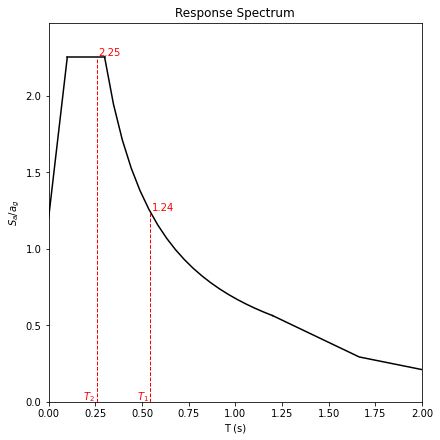

In [5]:
# Response Spectrum
T_spectrum = [0,0.10,0.30,1.2,10]       # Spectrum Parameters for D-type soil
S_0 = 1.8                               # Spectrum Parameters for D-type soil
resp_spectrum = [lambda t: S_0*(2/3 + (t/T_spectrum[1])*(2.5/q - 2/3)),
                 lambda t: S_0*(2.5/q) if (isinstance(t, float)) else S_0*(2.5/q)*np.ones(len(t)),
                 lambda t: S_0*(2.5/q)*(T_spectrum[2]/t),
                 lambda t: S_0*(2.5/q)*((T_spectrum[2]*T_spectrum[3])/(t**2))]

# Seismic Response
S_a = np.zeros(Tn.shape)
for i_mode,Tn_i in enumerate(Tn):
    if Tn_i < T_spectrum[1]: 
        S_a[i_mode] = a_g * resp_spectrum[0](Tn_i)
    elif Tn_i > T_spectrum[1] and Tn_i < T_spectrum[2]:
        S_a[i_mode] = a_g * resp_spectrum[1](Tn_i)
    elif Tn_i > T_spectrum[2] and Tn_i < T_spectrum[3]:
        S_a[i_mode] = a_g * resp_spectrum[2](Tn_i)
    elif Tn_i > T_spectrum[3]:
        S_a[i_mode] = a_g * resp_spectrum[3](Tn_i)
        # Plotting the response spectrum
plt.figure(figsize=(6.00, 6.00),constrained_layout=True)
for i_curve in range(len(resp_spectrum)):
    t = np.linspace(T_spectrum[i_curve],T_spectrum[i_curve+1],20,endpoint=True)
    S_norm = resp_spectrum[i_curve](t)
    plt.plot(t,S_norm,'-k',lw=1.5)
for i_mode,Tn_i in enumerate(Tn):
        plt.vlines(x=Tn_i, ymin=0, ymax=S_a[i_mode]/a_g, color='red', linestyle='--',lw=1)
        plt.text(x=Tn_i+0.01, y=S_a[i_mode]/a_g+0.01, s=str(np.round(S_a[i_mode]/a_g,2)), fontsize=10,color='red')
        plt.text(x=Tn_i-0.07, y=0.01, s='$T_{'+str(i_mode+1)+'}$', fontsize=10,color='red')
plt.title('Response Spectrum')
plt.xlabel('T (s)')
plt.ylabel('$S_{a}/a_{g}$')
plt.xlim([0,2])
plt.ylim([0,1.1*resp_spectrum[1](T_spectrum[1])])

print('The maximum acceleration responses are')
print(str(np.around(S_a,3)) + ' m/s2')
print( )

**Having obtained the maximum acceleration responses with the response spectrum, the modal analysis and combination is done:**

In [6]:
# Modal Analysis
eta_max = gamma_mod * S_a/(wn**2)           # max modal displacements
u_floor = phi[1,:] * eta_max                # spatial displacements at first floor
u_floor_max = np.sqrt(np.sum(u_floor**2))   # combined displacement at first floor by SRSS
u_floor_real = q * u_floor_max
    # Base shear
Fs_max = gamma_mod*S_a*(M @ phi)        # max forces in each DOF for each mode
V_max = np.sum(Fs_max,axis=0)           # base shear for each mode
V_max_tot = np.sqrt(np.sum(V_max**2))   # combined total base shear using SRSS
    # Overturning moment
M_max = np.sum(Fs_max*np.array([[L_1+L_2],[L_2]]),0)            # max overturning moment per mode
M_max_tot = np.sqrt(np.sum(M_max**2))   # combined total overturning moment using SRSS

print('The maximum modal displacements are')
print(eta_max)
print( )
print('The maximum displacements at 1st floor for each mode are')
print(str(np.around(1000*u_floor,2)) + ' mm')
print( )
print('The maximum displacement at 1st floor (combined using the SRSS rule)')
print(str(np.around(1000*u_floor_max,2)) + ' mm')
print( )
print('Multiplying this displacement with the behaviour factor we obtain the real maximum diplacement at the first floor')
print(str(np.around(1000*u_floor_real,2)) +' mm')
print( )
print('The maximum forces at each degree of freedom (rows) per mode (columns) are')
print(str(np.around(Fs_max,2)) +' N')
print( )
print('The base shear force for each mode')
print(str(np.around(V_max,2)) +' N')
print( )
print('The combined base shear force (using the SRSS rule)')
print(str(np.around(V_max_tot,2)) +' N')
print( )
print('The maximum overturning moment for each mode')
print(str(np.around(M_max,2)) +' Nm')
print( )
print('The combined overturning moment (using the SRSS rule)')
print(str(np.around(M_max_tot,2)) +' Nm')
print( )

The maximum modal displacements are
[ 0.00299083 -0.00026945]

The maximum displacements at 1st floor for each mode are
[1.31 0.41] mm

The maximum displacement at 1st floor (combined using the SRSS rule)
1.37 mm

Multiplying this displacement with the behaviour factor we obtain the real maximum diplacement at the first floor
2.74 mm

The maximum forces at each degree of freedom (rows) per mode (columns) are
[[ 7988.75 -3228.01]
 [ 5231.45  7394.05]] N

The base shear force for each mode
[13220.2   4166.04] N

The combined base shear force (using the SRSS rule)
13861.09 N

The maximum overturning moment for each mode
[76847.07  6980.16] Nm

The combined overturning moment (using the SRSS rule)
77163.43 Nm



### Part 2: Eurocode 8
**This part follows the same steps shown and explained in part two "Eurocode 8" of the file:**  
$Example$ - $Earthquake$ $Analysis$ $and$ $EC8$  

**EC 8 procedure for "Simple structures"**  
**First, the calculation of the fundamental period of the structure can be approximated** 

In [7]:
c_t = 0.075                             # EC 8, section 4.3.3.2.2 Base shear force, equation (4.6)
lambda_ec8 = 1.00                       # EC 8, section 4.3.3.2.2 Base shear force, equation (4.5)

T1_ec8 = c_t*((L_1+L_2)**(3/4))             # fundamental period

print('The first natural period is')
print(str(np.around(T1_ec8,3)) + ' s')
print( )

The first natural period is
0.323 s



**Next, the seismic base shear force is obtained**  

The acceleration response for the obtained fundamental period is
0.523 m/s2

The seismic base shear is
26141.0 N



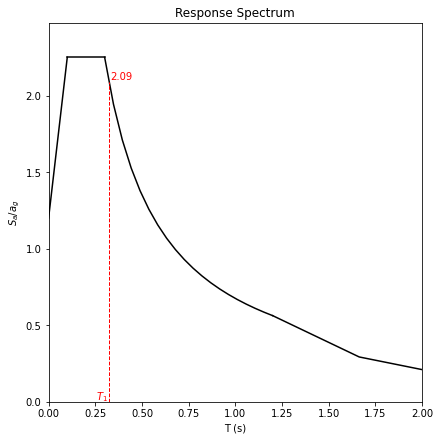

In [8]:
S_ec8 = a_g * resp_spectrum[2](T1_ec8)  # response spectrum
        # Plotting the response spectrum
plt.figure(figsize=(6.00, 6.00),constrained_layout=True)
for i_curve in range(len(resp_spectrum)):
    t = np.linspace(T_spectrum[i_curve],T_spectrum[i_curve+1],20,endpoint=True)
    S_norm = resp_spectrum[i_curve](t)
    plt.plot(t,S_norm,'-k',lw=1.5)
plt.vlines(x=T1_ec8, ymin=0, ymax=S_ec8/a_g, color='red', linestyle='--',lw=1)
plt.text(x=T1_ec8+0.01, y=S_ec8/a_g+0.01, s=str(np.round(S_ec8/a_g,2)), fontsize=10,color='red')
plt.text(x=T1_ec8-0.07, y=0.01, s='$T_{1}$', fontsize=10,color='red')
plt.title('Response Spectrum')
plt.xlabel('T (s)')
plt.ylabel('$S_{a}/a_{g}$')
plt.xlim([0,2])
plt.ylim([0,1.1*resp_spectrum[1](T_spectrum[1])])

Fb_ec8 = S_ec8 * np.sum(np.diag(M)) * lambda_ec8

print('The acceleration response for the obtained fundamental period is')
print(str(np.around(S_ec8,3)) + ' m/s2')
print( )
print('The seismic base shear is')
print(str(np.around(Fb_ec8,0)) + ' N')
print( )

**Finally, the seismic base shear force can be distributed along each floor and thus compute the overturning moment** 

In [9]:
Fmax_ec8 = Fb_ec8 * ((np.diag(M))*(np.array([L_1+L_2,L_2]))/np.sum((np.diag(M))*(np.array([L_1+L_2,L_2]))))
Mmax_ec8 = np.sum(Fmax_ec8*np.array([L_1+L_2,L_2]))

print('The distributed forces on each degree of freedom are')
print(str(np.around(Fmax_ec8,0)) +' N')
print( )
print('The overturning moment is')
print(str(np.around(Mmax_ec8,0)) +' N*m')
print( )

The distributed forces on each degree of freedom are
[14076. 12065.] N

The overturning moment is
146794.0 N*m

